Submitters:

* Arthur Bražinskas
* Minh Ngo

# Lab 2: Inference in Graphical Models

### Machine Learning 2, 2016

* The lab exercises should be made in groups of two people.
* The deadline is Sunday, April 24, 23:59.
* Assignment should be sent to t.s.cohen at uva dot nl (Taco Cohen). The subject line of your email should be "[ML2_2016] lab#_lastname1\_lastname2". 
* Put your and your teammate's names in the body of the email
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file follows the same rule as the subject line.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact us.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* NOTE: test your code and make sure we can run your notebook / scripts!

### Introduction
In this assignment, we will implement the sum-product and max-sum algorithms for factor graphs over discrete variables. The relevant theory is covered in chapter 8 of Bishop's PRML book, in particular section 8.4. Read this chapter carefuly before continuing!

We will first implement sum-product and max-sum and apply it to a simple poly-tree structured factor graph for medical diagnosis. Then, we will implement a loopy version of the algorithms and use it for image denoising.

For this assignment we recommended you stick to numpy ndarrays (constructed with np.array, np.zeros, np.ones, etc.) as opposed to numpy matrices, because arrays can store n-dimensional arrays whereas matrices only work for 2d arrays. We need n-dimensional arrays in order to store conditional distributions with more than 1 conditioning variable. If you want to perform matrix multiplication on arrays, use the np.dot function; all infix operators including *, +, -, work element-wise on arrays.

## Part 1: The sum-product algorithm

We will implement a datastructure to store a factor graph and to facilitate computations on this graph. Recall that a factor graph consists of two types of nodes, factors and variables. Below you will find some classes for these node types to get you started. Carefully inspect this code and make sure you understand what it does; you will have to build on it later.

In [95]:
%pylab inline

np.set_printoptions(precision=4)

class Node(object):
    """
    Base-class for Nodes in a factor graph. Only instantiate sub-classes of Node.
    """
    def __init__(self, name):
        # A name for this Node, for printing purposes
        self.name = name
        
        # Neighbours in the graph, identified with their index in this list.
        # i.e. self.neighbours contains neighbour 0 through len(self.neighbours) - 1.
        self.neighbours = []
        
        # Reset the node-state (not the graph topology)
        self.reset()
        
    def reset(self):
        # Incoming messages; a dictionary mapping neighbours to messages.
        # That is, it maps  Node -> np.ndarray.
        self.in_msgs = {}
        
        # A set of neighbours for which this node has pending messages.
        # We use a python set object so we don't have to worry about duplicates.
        self.pending = set([])

    def add_neighbour(self, nb):
        self.neighbours.append(nb)

    def send_sp_msg(self, other):
        # To be implemented in subclass.
        raise Exception('Method send_sp_msg not implemented in base-class Node')
   
    def send_ms_msg(self, other):
        # To be implemented in subclass.
        raise Exception('Method send_ms_msg not implemented in base-class Node')
    
    def receive_msg(self, other, msg):
        # Store the incomming message, replacing previous messages from the same node
        self.in_msgs[other] = msg

        # TODO: add pending messages
        # self.pending.update(...)
    
    def __str__(self):
        # This is printed when using 'print node_instance'
        return self.name


class Variable(Node):
    def __init__(self, name, num_states):
        """
        Variable node constructor.
        Args:
            name: a name string for this node. Used for printing. 
            num_states: the number of states this variable can take.
            Allowable states run from 0 through (num_states - 1).
            For example, for a binary variable num_states=2,
            and the allowable states are 0, 1.
        """
        self.num_states = num_states
        
        # Call the base-class constructor
        super(Variable, self).__init__(name)
    
    def set_observed(self, observed_state):
        """
        Set this variable to an observed state.
        Args:
            observed_state: an integer value in [0, self.num_states - 1].
        """
        # Observed state is represented as a 1-of-N variable
        # Could be 0.0 for sum-product, but log(0.0) = -inf so a tiny value is preferable for max-sum
        self.observed_state[:] = 0.000001
        self.observed_state[observed_state] = 1.0
        
    def set_latent(self):
        """
        Erase an observed state for this variable and consider it latent again.
        """
        # No state is preferred, so set all entries of observed_state to 1.0
        # Using this representation we need not differentiate between observed and latent
        # variables when sending messages.
        self.observed_state[:] = 1.0
        
    def reset(self):
        super(Variable, self).reset()
        self.observed_state = np.ones(self.num_states)
        
    def marginal(self, Z=None):
        """
        Compute the marginal distribution of this Variable.
        It is assumed that message passing has completed when this function is called.
        Args:
            Z: an optional normalization constant can be passed in. If None is passed, Z is computed.
        Returns: marginal, Z. The first is a numpy array containing the normalized marginal distribution.
         Z is either equal to the input Z, or computed in this function (if Z=None was passed).
        """
        # TODO: compute marginal
        return None, Z
    
    def send_sp_msg(self, other):
        # TODO: implement Variable -> Factor message for sum-product
        pass
   
    def send_ms_msg(self, other):
        # TODO: implement Variable -> Factor message for max-sum
        pass

class Factor(Node):
    def __init__(self, name, f, neighbours):
        """
        Factor node constructor.
        Args:
            name: a name string for this node. Used for printing
            f: a numpy.ndarray with N axes, where N is the number of neighbours.
               That is, the axes of f correspond to variables, and the index along that axes corresponds to a value of that variable.
               Each axis of the array should have as many entries as the corresponding neighbour variable has states.
            neighbours: a list of neighbouring Variables. Bi-directional connections are created.
        """
        # Call the base-class constructor
        super(Factor, self).__init__(name)

        assert len(neighbours) == f.ndim, 'Factor function f should accept as many arguments as this Factor node has neighbours'
        
        for nb_ind in range(len(neighbours)):
            nb = neighbours[nb_ind]
            assert f.shape[nb_ind] == nb.num_states, 'The range of the factor function f is invalid for input %i %s' % (nb_ind, nb.name)
            self.add_neighbour(nb)
            nb.add_neighbour(self)

        self.f = f
        
    def send_sp_msg(self, other):
        # TODO: implement Factor -> Variable message for sum-product
        pass
   
    def send_ms_msg(self, other):
        # TODO: implement Factor -> Variable message for max-sum
        pass


Populating the interactive namespace from numpy and matplotlib


In [96]:
# returns all the messages from neighbours except the other
def get_neighbour_messages(self,other):
    mes = []
    for ne in self.neighbours:
        if ne==other: continue
        if ne not in self.in_msgs: raise Exception('Some messages are not still received')
        mes.append(self.in_msgs[ne])
    return mes
Node.get_neighbour_messages = get_neighbour_messages

In [97]:
# a procedure that sends messages
def send_msg_proc(self, other, mes):
    # print "mes "+self.name+"-->"+str(other.name)+" : "+ str(mes)
    other.receive_msg(self,mes)
    self.pending.remove(other)
Node.send_msg_proc = send_msg_proc

### 1.1 Instantiate network (10 points)
Convert the directed graphical model ("Bayesian Network") shown below to a factor graph. Instantiate this graph by creating Variable and Factor instances and linking them according to the graph structure. 
To instantiate the factor graph, first create the Variable nodes and then create Factor nodes, passing a list of neighbour Variables to each Factor.
Use the following prior and conditional probabilities.

$$
p(\verb+Influenza+) = 0.05 \\\\
p(\verb+Smokes+) = 0.2 \\\\
$$

$$
p(\verb+SoreThroat+ = 1 | \verb+Influenza+ = 1) = 0.3 \\\\
p(\verb+SoreThroat+ = 1 | \verb+Influenza+ = 0) = 0.001 \\\\
p(\verb+Fever+ = 1| \verb+Influenza+ = 1) = 0.9 \\\\
p(\verb+Fever+ = 1| \verb+Influenza+ = 0) = 0.05 \\\\
p(\verb+Bronchitis+ = 1 | \verb+Influenza+ = 1, \verb+Smokes+ = 1) = 0.99 \\\\
p(\verb+Bronchitis+ = 1 | \verb+Influenza+ = 1, \verb+Smokes+ = 0) = 0.9 \\\\
p(\verb+Bronchitis+ = 1 | \verb+Influenza+ = 0, \verb+Smokes+ = 1) = 0.7 \\\\
p(\verb+Bronchitis+ = 1 | \verb+Influenza+ = 0, \verb+Smokes+ = 0) = 0.0001 \\\\
p(\verb+Coughing+ = 1| \verb+Bronchitis+ = 1) = 0.8 \\\\
p(\verb+Coughing+ = 1| \verb+Bronchitis+ = 0) = 0.07 \\\\
p(\verb+Wheezing+ = 1| \verb+Bronchitis+ = 1) = 0.6 \\\\
p(\verb+Wheezing+ = 1| \verb+Bronchitis+ = 0) = 0.001 \\\\
$$

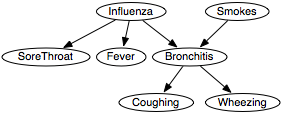

In [98]:
from IPython.core.display import Image 
Image(filename='bn.png') 

We have transformed the bayesian network to a factor graph as following:

![Imgur](http://i.imgur.com/cG2gNen.png)

where:

$$
f_1 = p(ST|I)\\\\
f_2 = p(F|I)\\\\
f_3 = p(B|I,S)\\\\
f_4 = p(C|B)\\\\
f_5 = p(W|B)\\\\
f_6 = p(S)\\\\
f_7 = p(I)
$$

In [99]:
# Variables
def init_variables():
    I = Variable('Influenza', 2)
    S = Variable('Smokes', 2)
    ST = Variable('SoreThroat', 2)
    F = Variable('Fever', 2)
    B = Variable('Bronchitits', 2)
    C = Variable('Coughing', 2)
    W = Variable('Wheezing', 2)
    return I, S, ST, F, B, C, W

$$
p(\verb+SoreThroat+ = 1 | \verb+Influenza+ = 1) = 0.3 \\\\
p(\verb+SoreThroat+ = 1 | \verb+Influenza+ = 0) = 0.001
$$

In [100]:
# Factor nodes

def init_f1(I, ST):
    # Order: I, ST
    f1_weights = np.empty((2, 2))

    f1_weights[1, 1] = 0.3
    f1_weights[0, 1] = 0.001

    f1_weights[:, 0] = 1 - f1_weights[:, 1]

    f1 = Factor('f1', f1_weights, [I, ST])
    return f1

$$
p(\verb+Fever+ = 1| \verb+Influenza+ = 1) = 0.9 \\\\
p(\verb+Fever+ = 1| \verb+Influenza+ = 0) = 0.05
$$

In [101]:
def init_f2(I, F):
    # Order: I, F
    f2_weights = np.empty((2, 2))

    f2_weights[1, 1]  = 0.9
    f2_weights[0, 1] = 0.05

    f2_weights[:, 0] = 1 - f2_weights[:, 1]

    f2 = Factor('f2', f2_weights, [I, F])
    return f2

$$
p(\verb+Bronchitis+ = 1 | \verb+Influenza+ = 1, \verb+Smokes+ = 1) = 0.99 \\\\
p(\verb+Bronchitis+ = 1 | \verb+Influenza+ = 1, \verb+Smokes+ = 0) = 0.9 \\\\
p(\verb+Bronchitis+ = 1 | \verb+Influenza+ = 0, \verb+Smokes+ = 1) = 0.7 \\\\
p(\verb+Bronchitis+ = 1 | \verb+Influenza+ = 0, \verb+Smokes+ = 0) = 0.0001
$$

In [102]:
def init_f3(I, S, B):
    # Order: I, S, B
    f3_weights = np.empty((2, 2, 2))

    f3_weights[1, 1, 1] = 0.99
    f3_weights[1, 0, 1] = 0.9
    f3_weights[0, 1, 1] = 0.7
    f3_weights[0, 0, 1] = 0.0001

    f3_weights[:, :, 0] = 1 - f3_weights[:, :, 1]
    
    f3 = Factor('f3', f3_weights, [I, S, B])
    return f3

$$
p(\verb+Coughing+ = 1| \verb+Bronchitis+ = 1) = 0.8 \\\\
p(\verb+Coughing+ = 1| \verb+Bronchitis+ = 0) = 0.07
$$

In [103]:
def init_f4(B, C):
    # Order: B, C
    f4_weights = np.empty((2, 2))

    f4_weights[1, 1] = 0.8
    f4_weights[0, 1] = 0.07

    f4_weights[:, 0] = 1 - f4_weights[:, 1]

    f4 = Factor('f4', f4_weights, [B, C])
    return f4

$$
p(\verb+Wheezing+ = 1| \verb+Bronchitis+ = 1) = 0.6 \\\\
p(\verb+Wheezing+ = 1| \verb+Bronchitis+ = 0) = 0.001
$$

In [104]:
def init_f5(B, W):
    # Order: B, W
    f5_weights = np.empty((2, 2))

    f5_weights[1, 1] = 0.6
    f5_weights[0, 1] = 0.001

    f5_weights[:, 0] = 1 - f5_weights[:, 1]

    f5 = Factor('f5', f5_weights, [B, W])
    return f5

$$
p(\verb+Smokes+) = 0.2
$$

In [105]:
def init_f6(S):
    f6_weights = np.array([0.8, 0.2])
    f6 = Factor('f6', f6_weights, [S])
    return f6

$$
p(\verb+Influenza+) = 0.05
$$

In [106]:
def init_f7(I):
    f7_weights = np.array([0.95, 0.05])
    f7 = Factor('f7', f7_weights, [I])
    return f7

### 1.2 Factor to variable messages (20 points)
Write a method `send_sp_msg(self, other)` for the Factor class, that checks if all the information required to pass a message to Variable `other` is present, computes the message and sends it to `other`. "Sending" here simply means calling the `receive_msg` function of the receiving node (we will implement this later). The message itself should be represented as a numpy array (np.array) whose length is equal to the number of states of the variable.

An elegant and efficient solution can be obtained using the n-way outer product of vectors. This product takes n vectors $\mathbf{x}^{(1)}, \ldots, \mathbf{x}^{(n)}$ and computes a $n$-dimensional tensor (ndarray) whose element $i_0,i_1,...,i_n$ is given by $\prod_j \mathbf{x}^{(j)}_{i_j}$. In python, this is realized as `np.multiply.reduce(np.ix_(*vectors))` for a python list `vectors` of 1D numpy arrays. Try to figure out how this statement works -- it contains some useful functional programming techniques. Another function that you may find useful in computing the message is `np.tensordot`.

In [107]:
def factor_send_sp_msg(self, other):
    assert isinstance(other,Variable)
    if other not in self.neighbours:
        raise Exception('The specified node is not a neighbour')

    factor_indexes = range(len(self.neighbours))
    factor_indexes.remove(self.neighbours.index(other))
    message_indexes = range(len(factor_indexes))
    
    # computing messages
    mes = self.get_neighbour_messages(other)
    mes = np.tensordot(self.f,np.multiply.reduce(np.ix_(*mes)),axes=(factor_indexes,message_indexes))

    # sending the message
    self.send_msg_proc(other,mes)
    
Factor.send_sp_msg=factor_send_sp_msg

### 1.3 Variable to factor messages (10 points)

Write a method `send_sp_message(self, other)` for the Variable class, that checks if all the information required to pass a message to Variable var is present, computes the message and sends it to factor.

In [108]:
def variable_send_sp_msg(self, other):
    assert isinstance(other, Factor)
    # checking if the target factor node has the current node in its neighbours
    assert self in other.neighbours
    # computing the message
    mes = np.prod(self.get_neighbour_messages(other),axis=0) * self.observed_state   
    self.send_msg_proc(other,mes)
        
Variable.send_sp_msg = variable_send_sp_msg

### 1.4 Compute marginal (10 points)
Later in this assignment, we will implement message passing schemes to do inference. Once the message passing has completed, we will want to compute local marginals for each variable.
Write the method `marginal` for the Variable class, that computes a marginal distribution over that node.

In [109]:
def variable_marginal(self, Z=None):
    """
    Compute the marginal distribution of this Variable.
    It is assumed that message passing has completed when this function is called.
    Args:
        Z: an optional normalization constant can be passed in. If None is passed, Z is computed.
    Returns: marginal, Z. The first is a numpy array containing the normalized marginal distribution.
     Z is either equal to the input Z, or computed in this function (if Z=None was passed).
    """
    mar = np.prod(self.in_msgs.values(),axis=0) * self.observed_state
    if Z==None:Z=sum(mar)
    return mar/Z, Z

Variable.marginal = variable_marginal

### 1.5 Receiving messages (10 points)
In order to implement the loopy and non-loopy message passing algorithms, we need some way to determine which nodes are ready to send messages to which neighbours. To do this in a way that works for both loopy and non-loopy algorithms, we make use of the concept of "pending messages", which is explained in Bishop (8.4.7): 
"we will say that a (variable or factor)
node a has a message pending on its link to a node b if node a has received any
message on any of its other links since the last time it send (sic) a message to b. Thus,
when a node receives a message on one of its links, this creates pending messages
on all of its other links."

Keep in mind that for the non-loopy algorithm, nodes may not have received any messages on some or all of their links. Therefore, before we say node a has a pending message for node b, we must check that node a has received all messages needed to compute the message that is to be sent to b.

Modify the function `receive_msg`, so that it updates the self.pending variable as described above. The member self.pending is a set that is to be filled with Nodes to which self has pending messages. Modify the `send_msg` functions to remove pending messages as they are sent.

In [110]:
def node_receive_msg(self, other, msg):
    # Store the incoming message, replacing previous messages from the same node
    self.in_msgs[other] = msg
    
#     print '%s receives message from %s: %s' % (self, other, msg)
    for neighbour in set(self.neighbours) - {other}:
        if neighbour in self.in_msgs:
            # If received all messages from neighbours
            if len(self.in_msgs) == len(self.neighbours):
                self.pending.update([neighbour])
        elif len(self.in_msgs) == len(self.neighbours) - 1:
            # If all incoming messages received
            self.pending.update([neighbour])

Node.receive_msg = node_receive_msg

### 1.6 Inference Engine (10 points)
Write a function `sum_product(node_list)` that runs the sum-product message passing algorithm on a tree-structured factor graph with given nodes. The input parameter `node_list` is a list of all Node instances in the graph, which is assumed to be ordered correctly. That is, the list starts with a leaf node, which can always send a message. Subsequent nodes in `node_list` should be capable of sending a message when the pending messages of preceding nodes in the list have been sent. The sum-product algorithm then proceeds by passing over the list from beginning to end, sending all pending messages at the nodes it encounters. Then, in reverse order, the algorithm traverses the list again and again sends all pending messages at each node as it is encountered. For this to work, you must initialize pending messages for all the leaf nodes, e.g. `influenza_prior.pending.add(influenza)`, where `influenza_prior` is a Factor node corresponding the the prior, `influenza` is a Variable node and the only connection of `influenza_prior` goes to `influenza`.




In [111]:
def apply_algorithm(node_list, func):
    for node in node_list:
        for other in list(node.pending):
            func(node, other)

def sum_product(node, other):
    node.send_sp_msg(other)

In [112]:
def configure_experiment():
    variables = init_variables()

    I, S, ST, F, B, C, W = variables

    f1 = init_f1(I, ST)
    f2 = init_f2(I, F)
    f3 = init_f3(I, S, B)
    f4 = init_f4(B, C)
    f5 = init_f5(B, W)
    f6 = init_f6(S)
    f7 = init_f7(I)

    f6.pending.update([S])
    f7.pending.update([I])

    ST.pending.update([f1])
    F.pending.update([f2])
    C.pending.update([f4])
    W.pending.update([f5])
    
    return (I, S, ST, F, B, C, W), (f1, f2, f3, f4, f5, f6, f7)

In [113]:
def print_marginals(variables):
    for variable in variables:
        marginal, Z = variable.marginal(None)
        print variable, marginal

In [114]:
variables, factors = configure_experiment()

I, S, ST, F, B, C, W = variables
f1, f2, f3, f4, f5, f6, f7 = factors

node_list = [f6, f7, W, C, F, f4, f5, S, f2, B, f3, I, f1, ST]

print '-----Forward pass-----'
apply_algorithm(node_list, sum_product)

ST.pending.update([f1])

print '-----Backward pass-----'
apply_algorithm(reversed(node_list), sum_product)

print '-----Marginals-----'
print_marginals(variables)

-----Forward pass-----
-----Backward pass-----
-----Marginals-----
Influenza [ 0.95  0.05]
Smokes [ 0.8  0.2]
SoreThroat [ 0.984   0.0159]
Fever [ 0.9075  0.0925]
Bronchitits [ 0.821  0.179]
Coughing [ 0.7993  0.2007]
Wheezing [ 0.8918  0.1082]


### 1.7 Observed variables and probabilistic queries (15 points)
We will now use the inference engine to answer probabilistic queries. That is, we will set certain variables to observed values, and obtain the marginals over latent variables. We have already provided functions `set_observed` and `set_latent` that manage a member of Variable called `observed_state`. Modify the `Variable.send_msg` and `Variable.marginal` routines that you wrote before, to use `observed_state` so as to get the required marginals when some nodes are observed.

In [115]:
variables, factors = configure_experiment()

I, S, ST, F, B, C, W = variables
f1, f2, f3, f4, f5, f6, f7 = factors

B.set_observed(1)

node_list = [f6, f7, W, C, F, f4, f5, S, f2, B, f3, I, f1, ST]

print 'Forward pass'
apply_algorithm(node_list, sum_product)

ST.pending.update([f1])

print 'Backward pass'
apply_algorithm(reversed(node_list), sum_product)

print_marginals(variables)

Forward pass
Backward pass
Influenza [ 0.7435  0.2565]
Smokes [ 0.2016  0.7984]
SoreThroat [ 0.9223  0.0777]
Fever [ 0.732  0.268]
Bronchitits [  4.5873e-06   1.0000e+00]
Coughing [ 0.2  0.8]
Wheezing [ 0.4  0.6]


### 1.8 Sum-product and MAP states (5 points)
A maximum a posteriori state (MAP-state) is an assignment of all latent variables that maximizes the probability of latent variables given observed variables:
$$
\mathbf{x}_{\verb+MAP+} = \arg\max _{\mathbf{x}} p(\mathbf{x} | \mathbf{y})
$$
Could we use the sum-product algorithm to obtain a MAP state? If yes, how? If no, why not?


**Answer**: It's possible to compute MAP by factorizing $p(x|y)$ into components and considering all possible combinations of its components, for example:

$$
p(x|y) = p(x_1)p(y_1|x_1)p(x_3|x_1)p(x_2|y_1)
$$

in the case of a bayesian network $y_1 \rightarrow x_2$, $x_1 \rightarrow x_3$, $y_1 \rightarrow x_1$, and $y_1$ is observed. By considering all possibilites of states $p(x_1)$, $p(y_1|x_1)$, etc and computing them using sum-product algorithm, we can compute MAP but it's not efficient, that's why we need max-sum.

Technically, we could compute conditional probabilities using sum-product by using set_observed() methods, which we used in the previous task. The main inefficiency is caused by the fact that we will be forced to recompute messages once the combination of initially observed states changes. 

## Part 2: The max-sum algorithm
Next, we implement the max-sum algorithm as described in section 8.4.5 of Bishop.

### 2.1 Factor to variable messages (10 points)
Implement the function `Factor.send_ms_msg` that sends Factor -> Variable messages for the max-sum algorithm. It is analogous to the `Factor.send_sp_msg` function you implemented before.

In [116]:
def factor_send_ms_msg(self, other):
    assert isinstance(other,Variable)
    if not other in self.neighbours:
        raise Exception('The specified node is not a neighbour')

    factor_indexes = range(len(self.neighbours))
    factor_indexes.remove(self.neighbours.index(other))

    mes = self.get_neighbour_messages(other)

    # computing messages
    mes = np.expand_dims(np.add.reduce(np.ix_(*mes)), self.neighbours.index(other))
    mes = np.apply_over_axes(np.amax, np.log(self.f)+mes,factor_indexes).squeeze()

    # sending the message
    self.send_msg_proc(other,mes)
        
Factor.send_ms_msg = factor_send_ms_msg

### 2.2 Variable to factor messages (10 points)
Implement the `Variable.send_ms_msg` function that sends Variable -> Factor messages for the max-sum algorithm.

In [117]:
def variable_send_ms_msg(self, other):
    assert isinstance(other, Factor)
    # checking if the target factor node has the current node in its neighbours
    assert self in other.neighbours
    # computing the message
    mes = np.sum(self.get_neighbour_messages(other),axis=0)+np.log(self.observed_state)
    self.send_msg_proc(other, mes)
        
Variable.send_ms_msg = variable_send_ms_msg

### 2.3 Find a MAP state (10 points)

Using the same message passing schedule we used for sum-product, implement the max-sum algorithm. For simplicity, we will ignore issues relating to non-unique maxima. So there is no need to implement backtracking; the MAP state is obtained by a per-node maximization (eq. 8.98 in Bishop). Make sure your algorithm works with both latent and observed variables.

In [118]:
def map_state(self):
    # Returns 0 state or 1
    return np.argmax(np.add.reduce(self.in_msgs.values()) + np.log(self.observed_state))

Variable.map_state = map_state

In [119]:
def max_sum(node, other):
    node.send_ms_msg(other)

In [120]:
def print_map_states(variables):
    for variable in variables:
        map_state = variable.map_state()
        print variable, map_state

In [121]:
variables, factors = configure_experiment()

I, S, ST, F, B, C, W = variables
f1, f2, f3, f4, f5, f6, f7 = factors

B.set_observed(1)

node_list = [f6, f7, W, C, F, f4, f5, S, f2, B, f3, I, f1, ST]

print 'Forward pass'
apply_algorithm(node_list, max_sum)

ST.pending.update([f1])

print 'Backward pass'
apply_algorithm(reversed(node_list), max_sum)

print_map_states(variables)

Forward pass
Backward pass
Influenza 0
Smokes 1
SoreThroat 0
Fever 0
Bronchitits 1
Coughing 1
Wheezing 1


## Part 3: Image Denoising and Loopy BP

Next, we will use a loopy version of max-sum to perform denoising on a binary image. The model itself is discussed in Bishop 8.3.3, but we will use loopy max-sum instead of Iterative Conditional Modes as Bishop does.

The following code creates some toy data. `im` is a quite large binary image, `test_im` is a smaller synthetic binary image. Noisy versions are also provided.

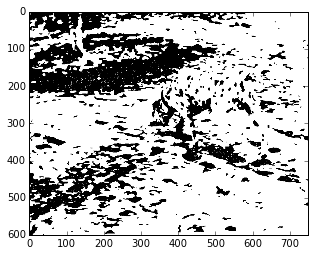

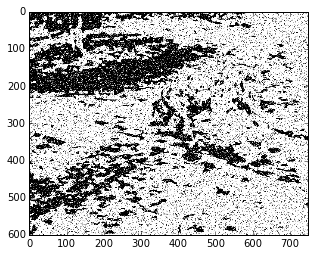

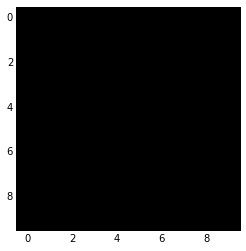

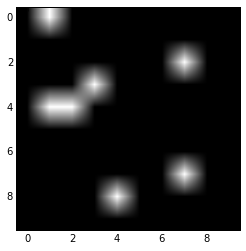

In [122]:
from pylab import imread, gray
# Load the image and binarize
im = np.mean(imread('dalmatian1.png'), axis=2) > 0.5
imshow(im)
gray()

# Add some noise
noise = np.random.rand(*im.shape) > 0.9
noise_im = np.logical_xor(noise, im)
figure()
imshow(noise_im)

test_im = np.zeros((10,10))
#test_im[5:8, 3:8] = 1.0
#test_im[5,5] = 1.0
figure()
imshow(test_im)

# Add some noise
noise = np.random.rand(*test_im.shape) > 0.9
noise_test_im = np.logical_xor(noise, test_im)
figure()
imshow(noise_test_im)

show()

### 3.1 Construct factor graph (10 points)
Convert the Markov Random Field (Bishop, fig. 8.31) to a factor graph and instantiate it.

In [123]:
def create_factor_graph(img):
    from itertools import product
    Y = np.empty(img.shape, dtype='object')
    X = np.empty(img.shape, dtype='object')
    fYX = np.empty(img.shape, dtype='object')
    fXR = np.empty((img.shape[0] - 1, img.shape[1] - 1), dtype='object')
    fXB = np.empty((img.shape[0] - 1, img.shape[1] - 1), dtype='object')
    
    init_prob = np.array([[0.8, 0.2], [0.2, 0.8]])
    
    for y, x in product(range(img.shape[0]), range(img.shape[1])):
        Y[y, x] = Variable('y(%d,%d)' % (x, y), 2)
        Y[y, x].set_observed(img[y, x])
        
        X[y, x] = Variable('x(%d,%d)' % (x, y), 2)
        
        fYX[y, x] = Factor('fXY(%d,%d)' % (x, y), init_prob, [Y[y, x], X[y, x]])
        
        Y[y, x].pending.update([fYX[y, x]])
    
    one_msg = np.ones(2)
    for y, x in product(range(img.shape[0] - 1), range(img.shape[1] - 1)):
        fXR[y, x] = Factor('fXR(%d,%d)' % (x, y), init_prob, [X[y, x], X[y, x + 1]])
        fXB[y, x] = Factor('fXB(%d,%d)' % (x, y), init_prob, [X[y, x], X[y + 1, x]])
        
        # Flooding schedule, simultaneously passing a message across every link in both direction
        # Bishop 8.4.7
        X[y, x].in_msgs[fXR[y, x]] = one_msg
        X[y, x].in_msgs[fXB[y, x]] = one_msg
        
        X[y, x + 1].in_msgs[fXR[y, x]] = one_msg
        X[y + 1, x].in_msgs[fXB[y, x]] = one_msg
    
    return Y, X, fYX, fXR, fXB

### 3.2 Loopy max-sum (10 points)
Implement the loopy max-sum algorithm, by passing messages from randomly chosen nodes iteratively until no more pending messages are created or a maximum number of iterations is reached. 

Think of a good way to initialize the messages in the graph.

In [124]:
def denoise(img, niter=10):
    from itertools import product
    Y, X, fYX, fXR, fXB = create_factor_graph(img)
    for i in range(niter):
        fXX = np.hstack((fXR.flatten(), fXB.flatten()))
        np.random.shuffle(fXX)
        
        # Preordered, first observed variables, then factors between observed variables and
        # corresponding laten variables, then all latent variables and then factors between
        # latents in the random order.
        node_list = np.hstack((Y.flatten(), fYX.flatten(), X.flatten(), fXX)).tolist()

        apply_algorithm(node_list, max_sum)
    result = np.zeros_like(img)
    for y, x in product(range(img.shape[0]), range(img.shape[1])):
        result[y, x] = X[y, x].map_state()
    return result

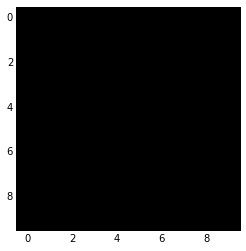

In [125]:
imshow(denoise(noise_test_im))
show()

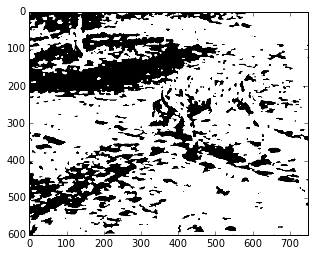

In [59]:
imshow(denoise(noise_im, niter=10))
show()